In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import plotly_express as px

import warnings
warnings.filterwarnings('ignore')

#from tqdm import tqdm
#tqdm.pandas()

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (12.0, 12.0)

In [2]:
import tensorflow as tf

In [4]:
def sin_transform(values):
    return np.sin(2*np.pi*values/len(set(values)))

def cos_transform(values):
    return np.cos(2*np.pi*values/len(set(values)))

In [5]:
import datetime

In [6]:
df = pd.read_csv("ucla2020-cs145-covid19-prediction/train.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [7]:
df.index = df['Date']

In [8]:
df = df[['Province_State', 'Confirmed', 'Deaths']]

In [9]:
df_1 = df.loc[df['Province_State']=='West Virginia', ]

In [10]:
df_1 = df_1[['Confirmed', 'Deaths']]

In [164]:
def split_dataset(data):
    train = data.loc[(data.index <= datetime.datetime.strptime('2020-08-03','%Y-%m-%d')) &
                     (data.index >= datetime.datetime.strptime('2020-04-14','%Y-%m-%d')), ]
    test = data.loc[(data.index > datetime.datetime.strptime('2020-08-03','%Y-%m-%d')) &
                    (data.index <= datetime.datetime.strptime('2020-08-31','%Y-%m-%d')), ]
# restructure into windows of weekly data
    train = np.array(np.split(train.values, len(train.values)/7))
    test = np.array(np.split(test.values, len(test.values)/7))
    return train, test

In [161]:
train, test = split_dataset(df_1)

In [162]:
print(train.shape)
print(test.shape)

(16, 7, 2)
(4, 7, 2)


In [ ]:
from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

In [318]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    score = 0
    actual_flat = np.array(actual).flatten()
    pred_flat = np.array(predicted).flatten()
    score = mean_squared_error(actual_flat, pred_flat)
    return score

# summarize scores
#def summarize_scores(name, score, scores):
 #   s_scores = ', '.join(['%.1f' % s for s in scores])
  #  print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=28):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(int(len(test)/4)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score = evaluate_forecasts(test[:, :, 0], predictions)
    pred = []
    for j in predictions:
        pred.append([i[0] for i in j])
    pred = np.array(pred).flatten()
    actual = []
    for j in history[-4:]:
        actual.append([i[0] for i in j])
    actual = np.array(actual).flatten()
    print('MAPE:', np.mean(np.abs((actual - pred) / actual)) * 100)
    return score, actual, pred

In [322]:
n_input = 56
score, actual, pred = evaluate_model(train, test, n_input)
# summarize scores
#summarize_scores('lstm', score, scores)
# plot scores
#pyplot.plot(days, scores, marker='o', label='lstm')
#pyplot.show()

MAPE: 64.37958732460972


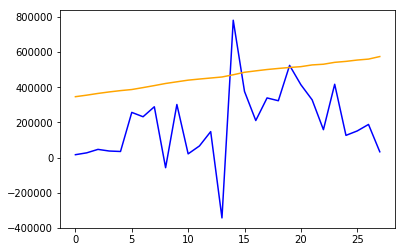

In [323]:
pyplot.plot(np.arange(0,28), pred, color= 'blue')
pyplot.plot(np.arange(0,28), actual, color = 'orange')

### Predict first difference (new cases everyday)

In [399]:
df_1 = df.loc[df['Province_State']=='California', ]
df_1 = df_1[['Confirmed', 'Deaths']]

In [400]:
df_1

,Confirmed,Deaths
Date,,
2020-04-12,22795,640
2020-04-13,23931,714
2020-04-14,25356,767
2020-04-15,26686,860
2020-04-16,27677,956
...,...,...
2020-08-27,691821,12677
2020-08-28,697385,12805
2020-08-29,702038,12894


In [401]:
df_1a = df_1.copy()
df_1a = df_1a.drop([datetime.datetime.strptime('2020-04-12','%Y-%m-%d')])

In [402]:
df_1.iloc[0,0]

22795

In [403]:
df_1a['Confirmed'] = np.diff(df_1['Confirmed'])
df_1a['Deaths'] = np.diff(df_1['Deaths'])

In [404]:
df_1a

,Confirmed,Deaths
Date,,
2020-04-13,1136,74
2020-04-14,1425,53
2020-04-15,1330,93
2020-04-16,991,96
2020-04-17,1480,81
...,...,...
2020-08-27,4817,145
2020-08-28,5564,128
2020-08-29,4653,89


In [405]:
def split_dataset(data):
    train = data.loc[(data.index <= datetime.datetime.strptime('2020-08-03','%Y-%m-%d')) &
                     (data.index >= datetime.datetime.strptime('2020-04-14','%Y-%m-%d')), ]
    test = data.loc[(data.index > datetime.datetime.strptime('2020-08-03','%Y-%m-%d')) &
                    (data.index <= datetime.datetime.strptime('2020-08-31','%Y-%m-%d')), ]
# restructure into windows of weekly data
    train = np.array(np.split(train.values, len(train.values)/7))
    test = np.array(np.split(test.values, len(test.values)/7))
    return train, test

In [406]:
train, test = split_dataset(df_1a)

In [407]:
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    score = 0
    actual_flat = np.array(actual).flatten()
    pred_flat = np.array(predicted).flatten()
    score = mean_squared_error(actual_flat, pred_flat)
    return score

# summarize scores
#def summarize_scores(name, score, scores):
 #   s_scores = ', '.join(['%.1f' % s for s in scores])
  #  print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 100, 32
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model

# make a forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_input):
    # fit model
    model = build_model(train, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(int(len(test))):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score = evaluate_forecasts(test[:, :, 0], predictions)
    pred = []
    for j in predictions:
        pred.append([i[0] for i in j])
    pred = np.array(pred).flatten()
    actual = []
    for j in history[-4:]:
        actual.append([i[0] for i in j])
    actual = np.array(actual).flatten()
    print('MAPE:', np.mean(np.abs((actual - pred) / actual)) * 100)
    return score, actual, pred

In [ ]:
n_input = 7
score, actual, pred = evaluate_model(train, test, n_input)
pyplot.plot(np.arange(0,28), pred, color= 'blue')
pyplot.plot(np.arange(0,28), actual, color = 'orange')

In [395]:
pred

array([101.04405 , 172.38014 , 160.29515 , 165.77171 , 133.54865 ,
       107.94736 , 111.397026, 154.40106 , 165.39676 , 132.83504 ,
       130.12904 ,  98.59145 ,  99.62699 , 104.964745, 113.317825,
       154.4244  , 142.93253 , 124.827545, 124.90381 , 101.19444 ,
       111.853455, 103.91414 , 127.28947 , 104.38729 , 105.74255 ,
        77.78453 ,  86.376335,  88.69531 ], dtype=float32)

In [396]:
actual

array([ 81, 103, 116, 174, 111, 132,  62, 122, 139, 145, 114, 185, 105,
        74,  97,  69, 180,  90, 108,  88,  42,  84, 145,  89, 193, 144,
       139, 140])

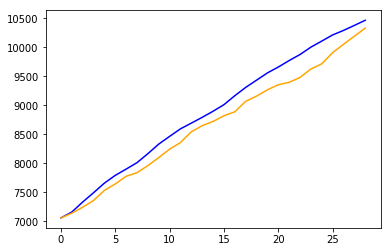

In [397]:
start_val = df_1.loc[df_1.index == datetime.datetime.strptime('2020-08-04','%Y-%m-%d'), ].values[0][0]
pred_list = pred.tolist()
pred_list = [start_val] + pred_list
pred_sum = np.cumsum(pred_list)
actual_list = actual.tolist()
actual_list = [start_val] + actual_list
actual_sum = np.cumsum(actual_list)
pyplot.plot(np.arange(0,29), pred_sum, color= 'blue')
pyplot.plot(np.arange(0,29), actual_sum, color = 'orange')

In [398]:
np.mean(np.abs((actual_sum - pred_sum) / actual_sum)) * 100

2.385042114319017